In [1]:
import numpy as np
import math
import os
import time
import re
import random

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec

from scipy.ndimage.filters import gaussian_filter
from skimage.morphology import square, disk, dilation

from PIL import Image
import pandas as pd
from scipy import ndimage

from correlation import *
from utils import *


In [100]:
def read_files_save_as_multitiff_stack(path, file_name):
    files = sorted([f for f in listdir(path) if isfile(join(path, f))])
    print(len(files))

    imlist = []
    for f in files:
        #im = np.array(Image.open(p + f))
        #imlist.append(Image.fromarray(m))
        with Image.open(path + f) as im:
            np_im = np.array(im)
            imlist.append(Image.fromarray(np_im))

    imlist[0].save(file_name, save_all=True, append_images=imlist[1:])

    print('Convertion to multitiff is done')

In [ ]:
#------------------------------
# Collect results
#------------------------------

from os import listdir
from os.path import isfile, join

path = 'y:\\projects\\pn-reduction\\2018_03_esrf_mi1325\\Phantom\\Glasduese\\Nachtschicht 09.3 auf 10.3\\025_1\\Ansicht 0°\\OP_1bar_25°C_100bar_25°C\\Z0Y0\\'
path_proc = 'proc_new\\'
path_amp = 'amp\\'
path_corr = 'corr\\'

dates = '09.3-10.3'
geometry = '025_1'
region = 'Z0Y0'

p = path + path_proc + path_amp

read_files_save_as_multitiff_stack(path + path_proc + path_amp, path + path_proc + geometry + '_' + region + '_amp_seq.tif')
read_files_save_as_multitiff_stack(path + path_proc + path_corr, path + path_proc + geometry + '_' + region + '_corr_seq.tif')


In [115]:
pixel_size = 3.0 # pixel size in micrometers
bunch_period = 176  # 176 ns bunch separation period
time_factor = bunch_period / 1000.0   # in microseconds
vel_factor = pixel_size / time_factor


sample_rate = 31.25 # sample rate = 32000 fps -> frame separation 31,2 microseconds

bern_vel = 250.0

# Number of shots for intergrated analysis
shots_num = 5
# Sequence length
seq_length = 40

# Radius of the pacth for overall statistics analysis
rx = 40
ry = 20

print('Velocity per pixel = {0:.2f} m/s'.format(vel_factor))
print('Bernoulli limit {0:.2f} m/s = {1:.2f} pixels'.format(bern_vel, bern_vel / vel_factor))
print('')
print('Velocity examples {0:d} pixel = {1:.2f} m/s'.format(6, 6*vel_factor))
print('Velocity examples {0:d} pixel = {1:.2f} m/s'.format(7, 7*vel_factor))
print('Velocity examples {0:d} pixel = {1:.2f} m/s'.format(10, 10*vel_factor))


Velocity per pixel = 17.05 m/s
Bernoulli limit 250.00 m/s = 14.67 pixels

Velocity examples 6 pixel = 102.27 m/s
Velocity examples 7 pixel = 119.32 m/s
Velocity examples 10 pixel = 170.45 m/s


In [102]:
#---------------------------
#   Colors
#---------------------------

blue = (57 / 255.0, 106 / 255.0, 177 / 255.0)
red = (204/ 255.0, 37/ 255.0, 41/ 255.0 )
green = (62/ 255.0, 150/ 255.0, 81/ 255.0 )  
grey = (128/ 255.0, 133/ 255.0, 133/ 255.0 )
gold = (237/ 255.0, 218/ 255.0, 116/ 255.0 )

#---------------------------
#   Fonts
#---------------------------

title_font_size = 20
label_font_size = 16
ticks_font_size = 16

In [155]:
dataset = '025_1_new'
region = 'Z0'

#path = '/Users/aleksejersov/data/spray/'+ dataset +'/'
path = 'e:\\Data\\spray\\correlation\\'+ dataset +'\\'

max_read_images = 200    

# Read dataset
start = time()
images = read_tiff(path + dataset + '_' + region +'_amp_seq.tif', max_read_images)
corr   = read_tiff(path + dataset + '_' + region +'_corr_seq.tif', max_read_images)
#cpeak   = read_tiff(path + dataset + '_' + region +'_cpeak_seq.tif', max_read_images)
end = time()

print ('Time elapsed: ', (end-start))

Time elapsed:  1.9041903018951416


In [153]:
#----------------------------#
# Time analysis              #
#----------------------------#
def time_analysis(images, cx, cy, rx, ry, y_pos=60, ax=None, region='all', show=False, filter_high=True, filter_zero=True, color='k'):
    
    if  not ax:
        ax  = plt.subplot(111)

    #def avg_nonzero(a): 
    #    return np.mean(a[a > 0])

    all_shots_vel = []

    #for s in range(1):    
    for s in range(shots_num):
        # Get sequence for the shot
        seq = images[s*seq_length:(s+1)*seq_length]

        mean_vel_values = []

        #for i in range(1):
        for i in range(seq_length): 

            im = seq[i][cy-ry:cy+ry,cx-rx:cx+rx]
            #print(cy-r_2, cx-r_2)

            # Filtering
            # 1. Put away large velocity outliers
            #filtered_amp = np.where(im < 10, im, 0)
            if filter_high:
                im = np.where(im < 10, im, 0)
            # 2. Drop zero velocities from avareging
            if filter_zero:
                im = np.mean(im[im > 0])
            #amp_nonzeros_mean = np.mean(filtered_amp[filtered_amp > 0])
            if not (filter_high and filter_zero):
                im = np.mean(im)
                

            # Convert to m/s
            im = im*vel_factor
            #amp_nonzeros_mean = amp_nonzeros_mean*vel_factor

            mean_vel_values.append(im)
            #mean_vel_values.append(amp_nonzeros_mean)

        all_shots_vel.append(mean_vel_values)
        #ax.plot(mean_vel_values, linewidth=1.0, alpha=0.3)

    all_shots_mean = np.mean(np.array(all_shots_vel), axis=0)
    ax.plot(all_shots_mean, linewidth=2.0, color=color, linestyle='dashed')

    
    ax.set_title('Velocity evolution, region: ' + region, size=title_font_size)
    
    x_lables = ['{:.1f}'.format(x) for x in np.arange(20, (20+seq_length)+1, 5)*sample_rate / 1000]
    x_ticks = np.arange(0, seq_length+1, 5)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_lables, fontsize = ticks_font_size)
    
    ax.set_ylabel('velocity, [m\s]', size=label_font_size)
    ax.set_xlabel('time from injection, [s]', size=label_font_size)


    overall_mean = np.mean(all_shots_mean)
    overall_std = np.std(all_shots_mean)

    #print('Overall average in region {0:.2f} m/s'.format(overall_mean))
    #print('Overall variation in region {0:.2f} m/s'.format(overall_std))
    #print('Variation in percent {0:.1f} %'.format(overall_std / overall_mean * 100))
    
    ax.text(1, y_pos, 'Mean: {0:.2f} m/s'.format(overall_mean), fontsize=14, color=color)
    ax.text(16, y_pos, 'STD: {0:.2f} m/s'.format(overall_std), fontsize=14, color=color)

    ax.set_ylim(50,140)
    ax.yaxis.set_tick_params(labelsize=label_font_size)
    
    if show:
        plt.show()
        
    return overall_mean, overall_std


        




All filters


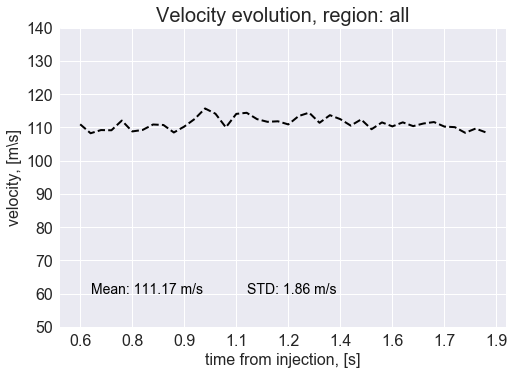

(111.1690408668735, 1.8634431766024486)

In [175]:
w = images[0].shape[1]
h = images[0].shape[0]

cx = int(w/2)
cy = int(h/2)
    
print('All filters')
time_analysis(images, cx, cy, rx, ry, 60, show=True)

#print('\nNo high')
#time_analysis(images, show=True, filter_high=False, filter_zero=True)

#print('\nNo filtering')
#time_analysis(images, show=True, filter_high=False, filter_zero=False)

In [157]:
#for i in range(images.shape[0]):

#for i in range(1,200):
#    mean_im = np.mean(images[:i], axis=0)
    
#    im_res = Image.fromarray(mean_im)
#    im_res.save(path + 'mean_test\\' + dataset + '_' + region + '_'+ str(i).zfill(3) +'_cum_mean.tif')
    
    

In [158]:
# Make masking
med = np.median(images, axis=0)

In [159]:
thres = np.where(med > 5, 255.0, 0.0)
dilated = dilation(thres, disk(6))
mask = gaussian_filter(dilated, 3.5)


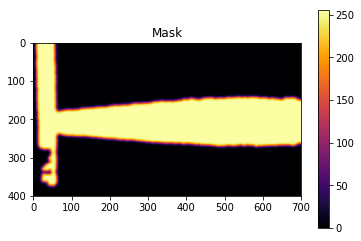

In [160]:
plt.imshow(mask, cmap='inferno')
plt.grid(False)
plt.title('Mask')
plt.colorbar()
plt.show()

im_res = Image.fromarray(mask)
im_res.save(path + dataset + '_' + region +'_mask.tif')

In [161]:
amp_mean = np.mean(images, axis=0)

im_res = Image.fromarray(amp_mean)
im_res.save(path + dataset + '_' + region +'_amp_mean_nofilter.tif')

# Filtering according to physical contraints
filtered_amp = np.where(images < 10, images, 0)
#filtered_amp = images # no filtering
#filtered_amp = np.where(np.abs(images) < 10, images, 0) # Filter y-components
filtered_corr = np.where(corr > 0.2, 1, 0)
filtered_amp = filtered_amp*filtered_corr


print(filtered_amp.shape)

(200, 400, 700)


In [163]:
use_masking = False
mask = mask / 255.0
  
amp_mean = np.mean(filtered_amp, axis=0)

#plt.imshow(amp_mean, vmin=0.5, cmap='inferno')
#plt.title('Original')
#plt.colorbar()
#plt.show()

#im_res = Image.fromarray(amp_mean)
#im_res.save(path + dataset + '_' + region +'_amp_mean.tif')

if use_masking: 
#    plt.imshow(amp_mean_m, cmap='inferno')
#    plt.title('Full masking')
#    plt.colorbar()
#    plt.show()
#
#    im_res = Image.fromarray(amp_mean_m)
#    im_res.save(path + dataset + '_' + region +'_amp_mean_m_full.tif')
#
    inv_mask = np.abs(mask - 1.0)*0.5
    amp_mean_v2 = (amp_mean * mask + amp_mean * inv_mask)
#
#    plt.imshow(amp_mean_v2,vmin=0.5, cmap='inferno')
#    plt.title('50% masking')
#    plt.colorbar()
#    plt.show()
#
    im_res = Image.fromarray(amp_mean_v2)
    im_res.save(path + dataset + '_' + region +'_amp_mean_masked.tif')

C:\Anaconda2\envs\py36\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Anaconda2\envs\py36\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


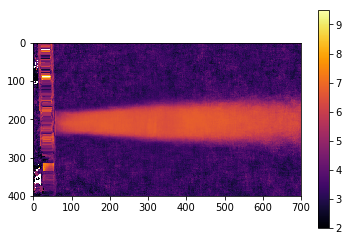

In [164]:
def avg_nonzero(a): 
    return np.mean(a[a > 0])
    
amp_nonzeros_mean = np.apply_along_axis(avg_nonzero, 0, filtered_amp)

plt.imshow(amp_nonzeros_mean, cmap='inferno')
plt.colorbar()
plt.show()

im_res = Image.fromarray(amp_nonzeros_mean)
im_res.save(path + dataset + '_' + region +'_amp_mean_filter.tif')


In [165]:
if use_masking:
    #inv_mask = np.abs(mask - 1.0)*0.3
    amp_nonzeros_mean = (amp_nonzeros_mean * mask + amp_nonzeros_mean * inv_mask)
    
    plt.imshow(amp_nonzeros_mean, cmap='inferno')
    plt.colorbar()
    plt.show()

    im_res = Image.fromarray(amp_nonzeros_mean)
    im_res.save(path + dataset + '_' + region +'_amp_mean_filter_masked.tif')

In [ ]:
# Additional test

In [76]:
def sum_nonzero(a): 
    return np.sum(a[a > 0])

corr_nonzeros_sum = np.apply_along_axis(sum_nonzero, 0, corr) 

In [166]:
print(corr_nonzeros_sum.shape)
#plt.imshow(corr_nonzeros_sum, cmap='inferno')
#plt.colorbar()
#plt.show()

im_res = Image.fromarray(corr_nonzeros_sum)
im_res.save(path + dataset + '_' + region +'_corr_sum_nonzeros.tif')

(400, 700)


In [78]:
corr_weights = corr / corr_nonzeros_sum
print(corr_weights.shape)

(200, 400, 700)


In [79]:
amp_weighted_mean = np.average(filtered_amp, weights=corr_weights, axis=0)

#corr_weights_mean = np.mean(corr_weights, axis)

In [80]:
if use_masking: 
    # Reduced masking
    inv_mask = np.abs(mask - 1.0)*0.3
    amp_weighted_mean = (amp_weighted_mean * mask + amp_weighted_mean * inv_mask)


im_res = Image.fromarray(amp_weighted_mean)
im_res.save(path + dataset + '_' + region +'_amp_weighted_mean.tif')

In [35]:
data = amp_mean

x_start = 85
x_end = data.shape[1]
center_y = 206
w = 10

# Small slab around the line
slice_x = data[center_y-int(w/2):center_y+int(w/2),x_start:x_end]
#slice_c = data[center_y,x_start:x_end] # Single slice

slice_mean = np.mean(slice_x, axis=0)
slice_std = np.std(slice_x, axis=0)

print(len(slice_mean))

615


In [36]:
IPython_default = plt.rcParams.copy()

In [168]:
plt.rcParams.update(IPython_default);

dataset = '025_1_new'
region = 'Z0'

path = 'e:\\Data\\spray\\correlation\\'+ dataset +'\\'

#measure_file = 'amp_weighted_mean'
#measure_file = 'amp_mean'
#measure_file = 'amp_mean'

measures = [('Mean velocity', 'amp_mean'),
           ('Weighted mean velocity', 'amp_weighted_mean'),
           ('Mean filtered velocity', 'amp_mean_filter'),  # Call it adaptive median velocity
           ('Mean non-filtered velocity', 'amp_mean_nofilter')
           ]

#-------------------------------
# Select measure
#-------------------------------
measure = measures[2]

mode_3_regions = False

measure_name = measure[0]
file_name = measure[1] + '.tif'
amp = np.array(Image.open(path + dataset + '_' + region + '_' + file_name))
if mode_3_regions:
    amp_pos2 = np.array(Image.open(path + dataset + '_' + 'Z2' + file_name))
    amp_pos5 = np.array(Image.open(path + dataset + '_' + 'Z5' + file_name))

print(amp_pos0.shape)

if mode_3_regions:
    pano = np.hstack((amp, amp_pos2, amp_pos5))*vel_factor
else:
    pano = amp*vel_factor

(400, 700)


In [169]:
# Load velocities sequences
file_name = '_' + 'amp_seq' + '.tif'
amp_seq = read_tiff(path + dataset + '_' + 'Z0' +'_amp_seq.tif', max_read_images)
if mode_3_regions:
    amp_pos2_seq = read_tiff(path + dataset + '_' + 'Z2' +'_amp_seq.tif', max_read_images)
    amp_pos5_seq = read_tiff(path + dataset + '_' + 'Z5' +'_amp_seq.tif', max_read_images)


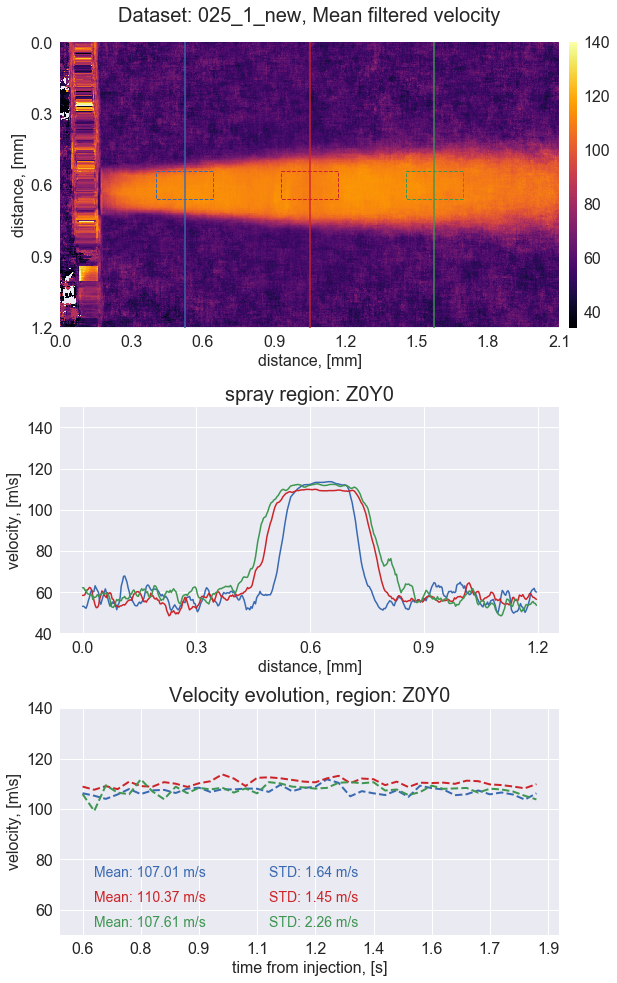

In [183]:

import matplotlib as mpl

# Setup figure

fig = plt.figure(1)

if mode_3_regions:
    fig.set_size_inches(20, 14, forward=True)
    plt.subplots_adjust(top=0.98, bottom=0.08, left=0.05, right=0.93, hspace=0.3 )
else:
    fig.set_size_inches(20/3 + 2, 14, forward=True)
    plt.subplots_adjust(top=0.95, bottom=0.06, left=0.1, right=0.90, hspace=0.3 )
    


if mode_3_regions:
    gs = gridspec.GridSpec(3, 3, height_ratios=[1.3,1,1])
else:
    gs = gridspec.GridSpec(3, 1, height_ratios=[1.3,1,1])
    
    
#-------------------------------------------
# Figure 1: Velocity maps
#-------------------------------------------

# Setup figure
ax0 = plt.subplot(gs[0,:])
                
cax = ax0.imshow(pano, vmax=140, cmap='inferno')
ax0.set_title('Dataset: '+ dataset +', '+ measure_name, size=title_font_size, y=1.05)    
ax0.set_xlabel('distance, [mm]', size=label_font_size)
ax0.set_ylabel('distance, [mm]', size=label_font_size)

width = pano.shape[1]
x_lables = ['{:.1f}'.format(x) for x in np.arange(0, width+1, 100) /1000*pixel_size]
x_ticks = np.arange(0, width+1, 100)
ax0.set_xticks(x_ticks)
ax0.set_xticklabels(x_lables, fontsize = ticks_font_size)

height = pano.shape[0]
y_lables = ['{:.1f}'.format(x) for x in np.arange(0, height+1, 100) /1000*pixel_size]
y_ticks = np.arange(0, height+1, 100)
ax0.set_yticks(y_ticks)
ax0.set_yticklabels(y_lables)

ax0.yaxis.set_tick_params(labelsize=label_font_size)

axins0 = inset_axes(ax0,
                   width="1.5%",  # width = 10% of parent_bbox width
                   height="100%",  # height : 50%
                   loc=3,
                   bbox_to_anchor=(1.02, 0., 1, 1),
                   bbox_transform=ax0.transAxes,
                   borderpad=0                    
                   )

# Separation lines between combined images
if mode_3_regions:
    ax0.axvline(700,linewidth=3, color='k')
    ax0.axvline(700*2,linewidth=3, color='k')

clb = plt.colorbar(cax, axins0)
clb.ax.tick_params(labelsize=ticks_font_size)

step = int(350 / 2)

ax0.axvline(step*1,linewidth=2, color=blue, alpha=0.7)
ax0.axvline(step*2,linewidth=2, color=red, alpha=0.7)
ax0.axvline(step*3,linewidth=2, color=green, alpha=0.7)

if mode_3_regions:
    ax0.axvline(step*5,linewidth=2, color=blue, alpha=0.7)
    ax0.axvline(step*6,linewidth=2, color=red, alpha=0.7)
    ax0.axvline(step*7,linewidth=2, color=green, alpha=0.7)

    ax0.axvline(step*9,linewidth=2, color=blue, alpha=0.7)
    ax0.axvline(step*10,linewidth=2, color=red, alpha=0.7)
    ax0.axvline(step*11,linewidth=2, color=green, alpha=0.7)

# Create a Rectangle patch
rect1 = patches.Rectangle((step*1 - rx, height/2-ry),2*rx,2*ry,linewidth=1, linestyle='--',edgecolor=blue,facecolor='none', alpha=1.0)
ax0.add_patch(rect1)

rect2 = patches.Rectangle((step*2 - rx, height/2-ry),2*rx,2*ry,linewidth=1, linestyle='--',edgecolor=red,facecolor='none', alpha=1.0)
ax0.add_patch(rect2)

rect3 = patches.Rectangle((step*3 - rx, height/2-ry),2*rx,2*ry,linewidth=1, linestyle='--',edgecolor=green,facecolor='none', alpha=1.0)
ax0.add_patch(rect3)

if mode_3_regions:
    rect2 = patches.Rectangle((step*6 - rx, height/2-ry),2*rx,2*ry,linewidth=1, linestyle='--',edgecolor=red,facecolor='none', alpha=1.0)
    rect3 = patches.Rectangle((step*10 - rx, height/2-ry),2*rx,2*ry,linewidth=1, linestyle='--',edgecolor=red,facecolor='none', alpha=1.0)
    ax0.add_patch(rect2)
    ax0.add_patch(rect3)


ax0.grid(False)
    
#plt.show()
#fig.savefig(path + dataset + '_comb_' + measure[1] + '_map.png')


#-------------------------------------------
# Figure 2: Velocity profiles
#-------------------------------------------

plt.style.use('seaborn')

#fig.set_size_inches(25, 8, forward=True)
#plt.subplots_adjust(left=0.05, right=0.95, wspace=0.1)

data = pano

smooth_mask = 4

vel_min = 40
vel_max = 150


# Subplot 2
vel_profile_A = data[:,step*1]
vel_profile_B = data[:,step*2]
vel_profile_C = data[:,step*3]

np.savetxt(path + 'vel_profile_A.txt', vel_profile_A, fmt='%.5f')
np.savetxt(path + 'vel_profile_B.txt', vel_profile_B, fmt='%.5f')
np.savetxt(path + 'vel_profile_C.txt', vel_profile_C, fmt='%.5f')

ax1 = plt.subplot(gs[1,0])
ax1.set_title('spray region: Z0Y0', size=title_font_size)
ax1.plot(smooth(vel_profile_A, smooth_mask, 'flat'), linewidth=1.5, color=blue)
ax1.plot(smooth(vel_profile_B, smooth_mask, 'flat'), linewidth=1.5, color=red)
ax1.plot(smooth(vel_profile_C, smooth_mask, 'flat'), linewidth=1.5, color=green)
ax1.set_ylim(vel_min, vel_max)
ax1.set_ylabel('velocity, [m\s]', size=label_font_size)
ax1.set_xlabel('distance, [mm]', size=label_font_size)
ax1.set_xticks(y_ticks)
ax1.set_xticklabels(y_lables, fontsize = ticks_font_size)
ax1.yaxis.set_tick_params(labelsize=label_font_size)

if mode_3_regions:
    # Subplot 3
    ax2 = plt.subplot(gs[1,1])
    ax2.set_title('spray region: Z2.5Y0', size=title_font_size)
    ax2.plot(smooth(data[:,step*5], smooth_mask, 'flat'), linewidth=1.5, color=blue)
    ax2.plot(smooth(data[:,step*6], smooth_mask, 'flat'), linewidth=1.5, color=red)
    ax2.plot(smooth(data[:,step*7], smooth_mask, 'flat'), linewidth=1.5, color=green)
    ax2.set_ylim(vel_min, vel_max)
    ax2.set_xlabel('distance, [mm]', size=label_font_size)
    ax2.set_xticks(y_ticks)
    ax2.set_xticklabels(y_lables, fontsize = ticks_font_size)
    ax2.yaxis.set_tick_params(labelsize=label_font_size)

    # Subplot 4
    ax3 = plt.subplot(gs[1,2])
    ax3.set_title('spray region: Z5Y0', size=title_font_size)
    ax3.plot(smooth(data[:,step*9], smooth_mask, 'flat'), linewidth=1.5, color=blue)
    ax3.plot(smooth(data[:,step*10], smooth_mask, 'flat'), linewidth=1.5, color=red)
    ax3.plot(smooth(data[:,step*11], smooth_mask, 'flat'), linewidth=1.5, color=green)
    ax3.set_ylim(vel_min, vel_max)
    ax3.set_xlabel('distance, [mm]', size=label_font_size)
    ax3.set_xticks(y_ticks)
    ax3.set_xticklabels(y_lables, fontsize = ticks_font_size)
    ax3.yaxis.set_tick_params(labelsize=label_font_size)



#-------------------------------------------
# Figure 3: Velocity time evolution
#-------------------------------------------

filters = True

if measure == measures[3]: # Non-filtered velocity
    f_high = False
    f_zeros = False
else:
    f_high = True
    f_zeros = True
    
    

# Subplot 2
ax4 = plt.subplot(gs[2,0])
avg_vel_A, std_vel_A = time_analysis(amp_pos0_seq, int(width/4), int(height/2), rx, ry, 73, ax4, region='Z0Y0', filter_high=f_high, filter_zero=f_zeros, show=False, color=blue)
avg_vel_B, std_vel_B = time_analysis(amp_pos0_seq, int(width/2), int(height/2), rx, ry, 63, ax4, region='Z0Y0', filter_high=f_high, filter_zero=f_zeros, show=False, color=red)
avg_vel_C, std_vel_C = time_analysis(amp_pos0_seq, int(3*width/4), int(height/2), rx, ry, 53, ax4, region='Z0Y0', filter_high=f_high, filter_zero=f_zeros, show=False, color=green)

if mode_3_regions:
    ax5 = plt.subplot(gs[2,1])
    time_analysis(amp_pos2_seq, ax5, region='Z2.5Y0', filter_high=f_high, filter_zero=f_zeros, show=False)

    ax6 = plt.subplot(gs[2,2])
    time_analysis(amp_pos5_seq, ax6, region='Z5Y0', filter_high=f_high, filter_zero=f_zeros, show=False)

all_results_path = 'e:\\Data\\spray\\correlation\\analysis_all_plots\\'

#plt.show()
fig.savefig(path + dataset + '_comb_'+ measure[1] +'_fig.png')
fig.savefig(all_results_path + region + '\\' + dataset + '_comb_'+ measure[1] +'_fig.png')



200
Convertion to multitiff is done
200
Convertion to multitiff is done
